In [1]:
import os
from PIL import Image

In [3]:
first_class_train =  'data/1class_train/'
second_class_train =  'data/2class_train/'
third_class_train =  'data/3class_train/'

first_class_test = 'data/1class_test/'
second_class_test = 'data/2class_test/'
third_class_test = 'data/3class_test/'

In [4]:
def norm_image(img):
    """
    Normalize PIL image
    
    Normalizes luminance to (mean,std)=(0,1), and applies a [1%, 99%] contrast stretch
    """
    img_y, img_b, img_r = img.convert('YCbCr').split()
    
    img_y_np = np.asarray(img_y).astype(float)

    img_y_np /= 255
    img_y_np -= img_y_np.mean()
    img_y_np /= img_y_np.std()
    scale = np.max([np.abs(np.percentile(img_y_np, 1.0)),
                    np.abs(np.percentile(img_y_np, 99.0))])
    img_y_np = img_y_np / scale
    img_y_np = np.clip(img_y_np, -1.0, 1.0)
    img_y_np = (img_y_np + 1.0) / 2.0
    
    img_y_np = (img_y_np * 255 + 0.5).astype(np.uint8)

    img_y = Image.fromarray(img_y_np)

    img_ybr = Image.merge('YCbCr', (img_y, img_b, img_r))
    
    img_nrm = img_ybr.convert('RGB')
    
    return img_nrm

def norm_image_(img):
    print(type(img))
    return (img - 127) / 255

In [5]:
def imgToArray(image):
    x=image.convert('L')
    y=np.asarray(x.getdata(),dtype=np.float64).reshape((x.size[1],x.size[0]))
    y=np.asarray(y,dtype=np.uint8) 
    return (y - 127) / 255
    

In [6]:
def resize_image(img, size):

    n_x, n_y = img.size
    if n_y > n_x:
        n_y_new = size
        n_x_new = int(size * n_x / n_y + 0.5)
    else:
        n_x_new = size
        n_y_new = int(size * n_y / n_x + 0.5)

    img_res = img.resize((n_x_new, n_y_new), resample=PIL.Image.BICUBIC)

    img_pad = Image.new('RGB', (size, size), (128, 128, 128))
    ulc = ((size - n_x_new) // 2, (size - n_y_new) // 2)
    img_pad.paste(img_res, ulc)

    return img_pad


In [7]:
new_size = 224

def getImages_wo_resize(path):
    names = os.listdir(path)
    img_arr = []
    for name in names:
        p = path + name
        img = Image.open(p)
        img_arr.append(img)
    return img_arr

def getImages(path):
    names = os.listdir(path)
    img_arr = []
    for name in names:
        p = path + name
        img = Image.open(p)
        #print(p)
        img_arr.append(imgToArray(resize_image(norm_image(img), new_size)))
    return img_arr


def resize(img, size):
    #wpercent = basewidth / img.size[0]
    #hsize = int((float(img.size[1]) * float(wpercent)))
    #return img.resize((basewidth,hsize), Image.ANTIALIAS)
    return img.resize((size, size), Image.ANTIALIAS)

In [8]:
first_class_train_img = getImages(first_class_train)
second_class_train_img = getImages(second_class_train)
third_class_train_img = getImages(third_class_train)

first_class_test_img = getImages(first_class_test)
second_class_test_img = getImages(second_class_test)
third_class_test_img = getImages(third_class_test)

In [11]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils import np_utils

img_rows, img_cols = 224, 224 


Using Theano backend.


In [13]:
# make (X_train, y_train), (X_test, y_test)

import numpy as np

X_train = np.array(first_class_train_img + second_class_train_img +third_class_train_img)
y_train = np.array([np.repeat(0, len(first_class_train_img))] +
                    [np.repeat(1, len(second_class_train_img))] +
                    [np.repeat(2, len(second_class_train_img))])

X_test = np.array(first_class_test_img+ second_class_test_img+ third_class_test_img)
y_test = np.array([np.repeat(0, len(first_class_test_img))] +
                    [np.repeat(1, len(second_class_test_img))] +
                    [np.repeat(2, len(second_class_test_img))])

                              
len_train = len(first_class_train_img) + len(second_class_train_img) + len(third_class_train_img)
print(len(first_class_train_img))
print(X_train.shape)
print(len_train)

#X_train  = X_train.reshape(len_train)
y_train = y_train.reshape(len_train)


len_test = len(first_class_test_img) + len(second_class_test_img) + len(third_class_test_img)
#X_test = X_test.reshape(len_test)
y_test = y_test.reshape(len_test)

y_test.shape

1000
(3000, 224, 224)
3000


(300,)

In [14]:
img_rows, img_cols = 224, 224


In [18]:
#theano

X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
input_shape = (1, img_rows, img_cols)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
#X_train /= 255
#X_test /= 255

Y_train = np_utils.to_categorical(y_train, 3)
Y_test = np_utils.to_categorical(y_test, 3)

model = Sequential()
model.add(Convolution2D(20, 5, 5, border_mode='valid', input_shape=input_shape))
model.add(Activation('relu'))
model.add(Convolution2D(20, 5, 5))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
nb_epoch = 4

res = model.fit(X_train, Y_train, batch_size=128, nb_epoch=nb_epoch, verbose=1, validation_data=(X_test, Y_test), shuffle=True)
score = model.evaluate(X_test, Y_test, verbose=0)

Train on 3000 samples, validate on 300 samples
Epoch 1/4
3000/3000 [==============================] - 419s - loss: 2.6262 - acc: 0.3247 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 2/4
3000/3000 [==============================] - 408s - loss: 1.0906 - acc: 0.3697 - val_loss: 1.0799 - val_acc: 0.4133
Epoch 3/4
3000/3000 [==============================] - 406s - loss: 1.0423 - acc: 0.4627 - val_loss: 1.0714 - val_acc: 0.3800
Epoch 4/4
3000/3000 [==============================] - 405s - loss: 0.9340 - acc: 0.5703 - val_loss: 1.0777 - val_acc: 0.4133


### Recompile and run with 8 epoch

In [19]:
nb_epoch = 8

res = model.fit(X_train, Y_train, batch_size=128, nb_epoch=nb_epoch, verbose=1, validation_data=(X_test, Y_test), shuffle=True)
score = model.evaluate(X_test, Y_test, verbose=0)

Train on 3000 samples, validate on 300 samples
Epoch 1/8
3000/3000 [==============================] - 398s - loss: 1.5816 - acc: 0.3543 - val_loss: 1.0961 - val_acc: 0.3933
Epoch 2/8
3000/3000 [==============================] - 393s - loss: 1.0815 - acc: 0.4213 - val_loss: 1.0826 - val_acc: 0.4133
Epoch 3/8
3000/3000 [==============================] - 394s - loss: 1.0446 - acc: 0.4553 - val_loss: 1.0665 - val_acc: 0.4367
Epoch 4/8
3000/3000 [==============================] - 426s - loss: 0.9294 - acc: 0.5710 - val_loss: 1.0683 - val_acc: 0.4400
Epoch 5/8
3000/3000 [==============================] - 415s - loss: 0.7195 - acc: 0.7087 - val_loss: 1.1231 - val_acc: 0.4333
Epoch 6/8
3000/3000 [==============================] - 405s - loss: 0.4209 - acc: 0.8520 - val_loss: 1.3729 - val_acc: 0.4467
Epoch 7/8
3000/3000 [==============================] - 411s - loss: 0.2005 - acc: 0.9403 - val_loss: 1.8079 - val_acc: 0.4467
Epoch 8/8
3000/3000 [==============================] - 411s - loss: 0.1

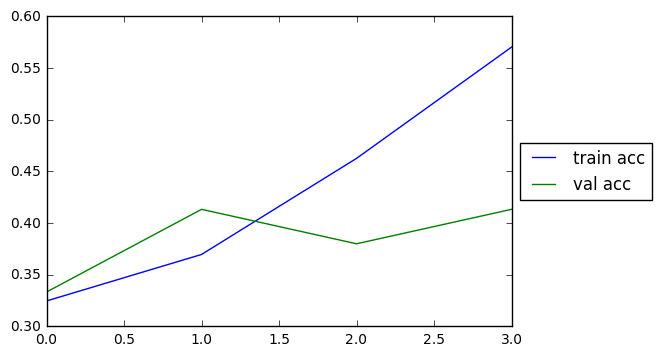

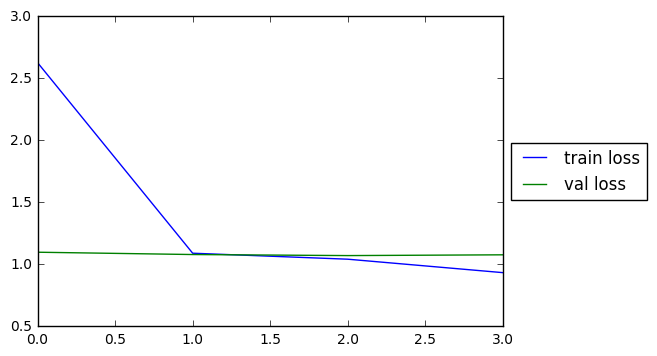

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

x = range(nb_epoch)

plt.plot(x, res.history['acc'], label="train acc")
plt.plot(x, res.history['val_acc'], label="val acc")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.plot(x, res.history['loss'], label="train loss")
plt.plot(x, res.history['val_loss'], label="val loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Graphics for 8 epoch

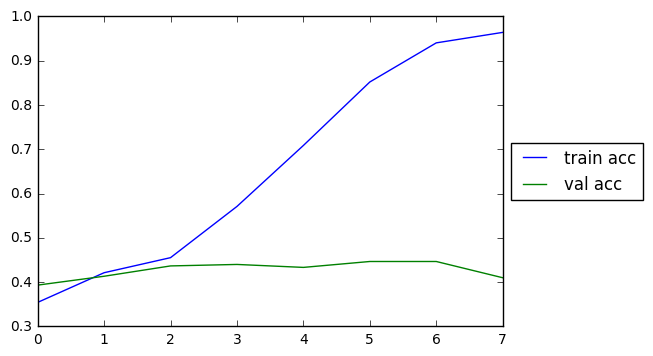

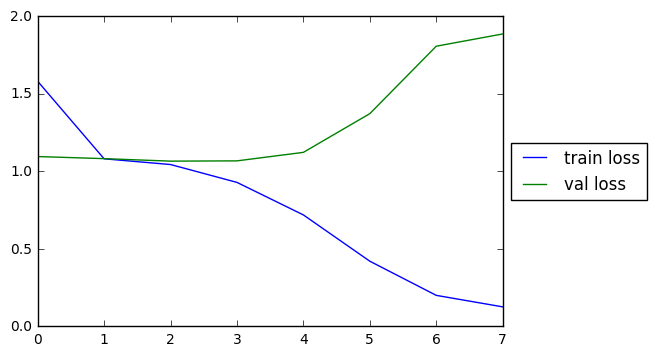

In [21]:
x = range(nb_epoch)

plt.plot(x, res.history['acc'], label="train acc")
plt.plot(x, res.history['val_acc'], label="val acc")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.plot(x, res.history['loss'], label="train loss")
plt.plot(x, res.history['val_loss'], label="val loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))